In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Train Autoencoder on image dataset

In [2]:
emoji_file_paths = []

ROOT = "public/Train"

for folder in os.listdir(ROOT):
    folder_path = os.path.join(ROOT, folder)
    folder_path = folder_path.replace("\\", "/")
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        file_path = file_path.replace("\\", "/")
        emoji_file_paths.append(file_path)

emoji_images = [load_img(file_path, target_size=(64, 64)) for file_path in emoji_file_paths]
emoji_images = np.array([img_to_array(img) for img in emoji_images])
emoji_images = emoji_images.astype('float32') / 255.0  # Normalize to [0, 1]

C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(emoji_images)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(64, 64, 3))  

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
batch_size = 32
epochs = 100

autoencoder.fit(datagen.flow(emoji_images, emoji_images, batch_size=batch_size),
                steps_per_epoch=len(emoji_images) / batch_size, epochs=epochs)

Epoch 1/100

395/395 [==============================] - 16s 37ms/step - loss: 0.5716
Epoch 2/100
395/395 [==============================] - 15s 37ms/step - loss: 0.5540
Epoch 3/100
395/395 [==============================] - 15s 39ms/step - loss: 0.5502
Epoch 4/100
395/395 [==============================] - 16s 39ms/step - loss: 0.5485
Epoch 5/100
395/395 [==============================] - 16s 40ms/step - loss: 0.5470
Epoch 6/100
395/395 [==============================] - 18s 44ms/step - loss: 0.5446
Epoch 7/100
395/395 [==============================] - 18s 45ms/step - loss: 0.5432
Epoch 8/100
395/395 [==============================] - 16s 41ms/step - loss: 0.5424
Epoch 9/100
395/395 [==============================] - 15s 38ms/step - loss: 0.5412
Epoch 10/100
395/395 [==============================] - 15s 39ms/step - loss: 0.5404
Epoch 11/100
395/395 [==============================] - 23s 58ms/step - loss: 0.5399
Epoch 12/100
395/395 [==============================] - 23s 58ms/step - l

# Predict latent representations of chosen emojis

In [6]:
emojis_dataset = []

ROOT = "public/Fine-tuning"

for file in os.listdir(ROOT):
    file_path = os.path.join(ROOT, file)
    file_path = file_path.replace("\\", "/")
    emojis_dataset.append(file_path)

emoji_images = [load_img(file_path, target_size=(64, 64)) for file_path in emojis_dataset]
emoji_images = np.array([img_to_array(img) for img in emoji_images])
emoji_images = emoji_images.astype('float32') / 255.0  # Normalize to [0, 1]

In [7]:
encoder = Model(input_img, encoded)
latent_representations = encoder.predict(emoji_images)

3/3 [==============================] - 0s 8ms/step


# Put predictions in df taken from textual model, pass the df to multimodel

In [25]:
import pandas as pd

with open('dictionary-text-1.json', 'r') as json_file:
    json_content = json_file.read()
    dictionary = pd.read_json(json_content, orient='split')

dictionary = dictionary.sort_values(by='name')

In [26]:
flattened = []

for repr in latent_representations:
    repr = repr.flatten()
    flattened.append(repr)

dictionary['visual_features'] = flattened

In [27]:
json_dictionary = dictionary.to_json(orient='split')

with open("dictionary-text-1.json", 'w') as json_file:
    json_file.write(json_dictionary)

# Passed file to multimodel

# Analysis (image features)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(latent_representations[0].reshape(1, -1), latent_representations[1].reshape(1, -1))
print("Similarity between first and second emoji:", similarity)

Similarity between first and second emoji: [[0.36559457]]


In [12]:
from sklearn.manifold import TSNE
import numpy as np

X = dictionary['visual_features'].tolist()
X = np.array(X)

n_samples, n_features = X.shape

print(X.shape)

X = X.reshape(n_samples, -1)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

df_tsne = pd.DataFrame(X_embedded, columns=['tsne_feature1', 'tsne_feature2'])
df_tsne['emoji_name'] = dictionary['name'].tolist()
df_tsne['emoji'] = dictionary.index

(94, 4096)


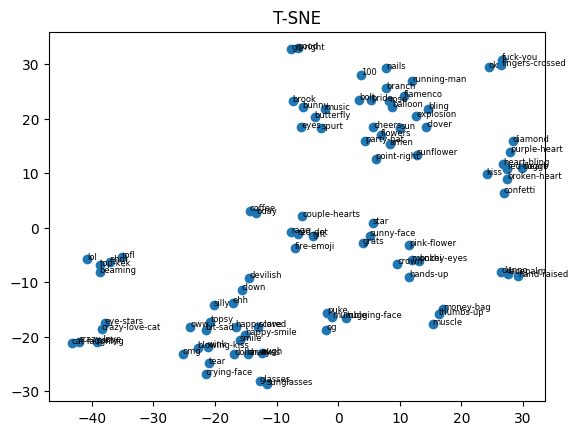

In [13]:
import matplotlib.pyplot as plt

plt.scatter(df_tsne['tsne_feature1'], df_tsne['tsne_feature2'], label=df_tsne['emoji_name'])

# Set labels and title
plt.title('T-SNE')

for i, txt in enumerate(df_tsne['emoji_name']):
    plt.annotate(txt, (df_tsne['tsne_feature1'][i], df_tsne['tsne_feature2'][i]), fontsize=6)


plt.show()

In [14]:
from itertools import combinations

emojis = dictionary.index.tolist()
emojis

pairs = list(combinations(emojis, 2))

df_pairs = pd.DataFrame(pairs, columns=['Emo1', 'Emo2'])

In [15]:
dictionary

json_dictionary = dictionary.to_json(orient='split')

with open("dictionary-text-viz.json", 'w') as json_file:
    json_file.write(json_dictionary)

In [16]:
with open('dictionary-text-1.json', 'r') as json_file:
    json_content = json_file.read()
    new_dict = pd.read_json(json_content, orient='split')

new_dict

,name,unicode,visual_features,embedding,mixed_features,dataset_count,freq_rank,sample_bias
💯,100,U0001F4AF,"[0.4189754128, 0.3792000413, 0.0, 0.0, 0.0, 0....","[-0.3559009433, -1.2132384777, -2.5393185616, ...",NaN,8464,40,-11
🙏,amen,U0001F64F,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[1.9877089262, -2.2331938744, -1.1079307795, 0...",NaN,36078,6,-1
😩,augh,U0001F629,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[-0.27658119800000003, -1.4465414286, 1.313793...",NaN,4064,39,6
🎈,balloon,U0001F388,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[-1.1368076801, -0.5875102282, -0.3490807414, ...",NaN,2030,42,25
🎂,bday,U0001F382,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[-1.0857384205, -1.0770434141, 0.2204059064000...",NaN,4111,23,21
...,...,...,...,...,...,...,...,...
😢,tear,U0001F622,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[0.14839348200000002, -0.27748221160000003, 1....",NaN,1460,37,38
👍,thumbs-up,U0001F44D,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[1.1695523262, 2.1495008469, -2.3972885609, 1....",NaN,27457,4,6
😆,top-kek,U0001F606,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[3.0894954205, -0.8971546292, 0.4259133339, -0...",NaN,4469,20,21
🙃,topsy,U0001F643,"[0.0, 0.3792000413, 0.0, 0.0, 0.0, 0.0, 0.1968...","[0.2647522986, -0.342417419, 1.4908359051, 0.9...",NaN,1942,53,16


In [17]:
merged_df = pd.merge(dictionary, df_pairs, left_index=True, right_on='Emo1', how='left')
merged_df = merged_df.drop(columns=['name', 'unicode', 'sample_bias', 'mixed_features', 'embedding', 'dataset_count', 'freq_rank'])
merged_df = merged_df.rename(columns={'visual_features': 'embedding_1'})

In [18]:
merged_df

,embedding_1,Emo1,Emo2
0.0,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🙏
1.0,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,😩
2.0,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🎈
3.0,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🎂
4.0,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,😁
...,...,...,...
4367.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",👍,😉
4368.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😆,🙃
4369.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😆,😉
4370.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",🙃,😉


In [19]:
merged_df = pd.merge(dictionary, merged_df, left_index=True, right_on='Emo2', how='left')
merged_df = merged_df.drop(columns=['name', 'unicode', 'sample_bias', 'embedding', 'mixed_features', 'dataset_count', 'freq_rank'])
merged_df = merged_df.rename(columns={'visual_features': 'embedding_2'})
merged_df

,embedding_2,embedding_1,Emo1,Emo2
NaN,"[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",NaN,NaN,💯
0.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🙏
1.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,😩
93.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",🙏,😩
2.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🎈
...,...,...,...,...
4360.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.41918027, 0.0, 0.0, 0.0, 0.0, 0.196878...",🌞,😉
4364.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😢,😉
4367.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",👍,😉
4369.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😆,😉


In [20]:
merged_df = merged_df.dropna()

merged_df

,embedding_2,embedding_1,Emo1,Emo2
0.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🙏
1.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,😩
93.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",🙏,😩
2.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0....",💯,🎈
94.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",🙏,🎈
...,...,...,...,...
4360.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.41918027, 0.0, 0.0, 0.0, 0.0, 0.196878...",🌞,😉
4364.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😢,😉
4367.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",👍,😉
4369.0,"[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...","[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.196878...",😆,😉


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
merged_df['embedding_1'] = merged_df.apply(lambda row: np.reshape(row['embedding_1'], (1, -1)), axis=1)
merged_df['embedding_2'] = merged_df.apply(lambda row: np.reshape(row['embedding_2'], (1, -1)), axis=1)

C:\Users\aless\AppData\Local\Temp\ipykernel_11328\1166528489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['embedding_1'] = merged_df.apply(lambda row: np.reshape(row['embedding_1'], (1, -1)), axis=1)
C:\Users\aless\AppData\Local\Temp\ipykernel_11328\1166528489.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['embedding_2'] = merged_df.apply(lambda row: np.reshape(row['embedding_2'], (1, -1)), axis=1)


In [23]:
merged_df['distances'] = merged_df.apply(lambda row: cosine_similarity(row['embedding_1'], row['embedding_2']), axis=1)

C:\Users\aless\AppData\Local\Temp\ipykernel_11328\3155338771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['distances'] = merged_df.apply(lambda row: cosine_similarity(row['embedding_1'], row['embedding_2']), axis=1)


In [24]:
merged_df

,embedding_2,embedding_1,Emo1,Emo2,distances
0.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0...",💯,🙏,[[0.36559457]]
1.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0...",💯,😩,[[0.43159738]]
93.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...",🙏,😩,[[0.32782924]]
2.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.4189754, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0...",💯,🎈,[[0.46688974]]
94.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...",🙏,🎈,[[0.4330535]]
...,...,...,...,...,...
4360.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.41918027, 0.0, 0.0, 0.0, 0.0, 0.19687...",🌞,😉,[[0.6279403]]
4364.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...",😢,😉,[[0.9437427]]
4367.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...",👍,😉,[[0.5044568]]
4369.0,"[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...","[[0.0, 0.37920004, 0.0, 0.0, 0.0, 0.0, 0.19687...",😆,😉,[[0.89097995]]
